In [1]:
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout, TimeDistributed, BatchNormalization, Flatten, Activation
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import numpy as np
import h5py
import matplotlib.pyplot as plt
from data_utils import get_data
from sklearn import preprocessing
from functools import reduce
from scipy.fftpack import dct, idct
from scipy import signal


Using TensorFlow backend.


In [2]:
# Load data from all .mat files, combine them, eliminate EOG signals, shuffle and 
# seperate training data, validation data and testing data.
# Also do mean subtraction on x.

data = get_data('project_datasets',num_validation=0, num_test=100, subtract_mean=False, subtract_axis=1,
                transpose=True)
for k in data.keys():
    print('{}: {} '.format(k, data[k].shape))

X_train: (2458, 1000, 22) 
y_train: (2458,) 
X_val: (0, 1000, 22) 
y_val: (0,) 
X_test: (100, 1000, 22) 
y_test: (100,) 


In [3]:
# substract data from list
X_train = data.get('X_train')
y_train = data.get('y_train')
#X_val = data.get('X_val')
#y_val = data.get('y_val')
X_test = data.get('X_test')
y_test = data.get('y_test')

# get data dimension
N_train, T_train, C_train = data.get('X_train').shape
N_val, T_val, C_val = data.get('X_val').shape
N_test, T_test, C_test = data.get('X_test').shape

# add dummy zeros for y classification
lb = preprocessing.LabelBinarizer()
lb.fit([0, 1, 2, 3,])
lb.classes_
y_train = lb.transform(y_train)
if (N_val > 0): y_val = lb.transform(y_val)
y_test = lb.transform(y_test)

In [4]:
# Filtering through FFT(discrete cosine transform)

def filter(x, low=0, high=1, plot=False):
    N = x.shape[0]
    t = np.linspace(0,N,N)
    y = dct(x, norm='ortho')
    window = np.zeros(N)
    window[int(low*N):int(high*N)] = 1
    yr = idct(y*window, norm='ortho')
    sum(abs(x-yr)**2) / sum(abs(x)**2)
    if plot:
        plt.plot(t, x, '-b')
        plt.plot(t, yr, 'r')
    return x

# Filter band
low_freq = 0.02
high_freq = 0.4

for i in np.arange(N_train):
    for j in np.arange(C_train):
       X_train[i,:,j]= filter(X_train[i,:,j],low_freq,high_freq)
for i in np.arange(N_val):
    for j in arange(C_val):
       X_val[i,:,j]= filter(X_val[i,:,j],low_freq,high_freq)
    
for i in np.arange(N_test):
    for j in np.arange(C_test):
       X_test[i,:,j]= filter(X_test[i,:,j],low_freq,high_freq)


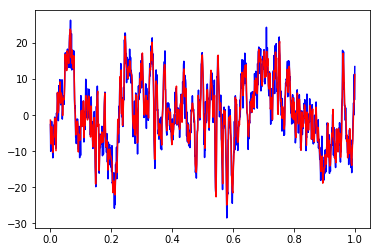

In [5]:
# Downsampling in time through FFT

t_sample = 600
X_train_sub = signal.resample(X_train,t_sample,axis=1)
if (N_val > 0): X_val_sub = signal.resample(X_val,t_sample,axis=1)
X_test_sub = signal.resample(X_test,t_sample,axis=1)

# show a downsampling example
plt.plot(np.linspace(0,1,T_train),X_train[5,:,5],'-b')
plt.plot(np.linspace(0,1,t_sample),X_train_sub[5,:,5],'-r')

In [6]:
print(X_train_sub.shape)

(2458, 600, 22)


In [7]:
# # normalize data across the time sequence dimension only
# scaler = preprocessing.MinMaxScaler()
# for i in range(N_train):
#     scaler.fit(X_train[i,:,:])
#     X_train[i,:,:] = scaler.transform(X_train[i,:,:])
    
# for i in range(N_val):
#     scaler.fit(X_val[i,:,:])
#     X_val[i,:,:] = scaler.transform(X_val[i,:,:])

In [8]:
# def downsample(data, mul=10, enableTrunc = False):
#     assert data.shape[0] % mul == 0 or  enableTrunc, "Can't downsample without data truncation.\
#                                                 \n Set another value of mul or set enableTrunc = True"
#     outdata = []
#     for i in range(data.shape[0]//mul):
#         outdata.append(np.mean(data[i*mul:(i+1)*mul,...], axis=0, keepdims=True))
#     outdata = reduce(lambda a,b: np.append(a,b,0), outdata)
    
#     return outdata
# span = 2
# X_train_sub = np.expand_dims(downsample(X_train[0,:,:], mul=span),axis=0)
# for n in np.arange(1,X_train.shape[0]):
#     X_train_sub = np.append(X_train_sub,
#                             np.expand_dims(downsample(X_train[n,:,:], mul=span),axis=0),axis=0)

# X_val_sub = np.expand_dims(downsample(X_val[0,:,:], mul=span),axis=0)
# for n in np.arange(1,X_val.shape[0]):
#     X_val_sub = np.append(X_val_sub,
#                             np.expand_dims(downsample(X_val[n,:,:], mul=span),axis=0),axis=0)

# print('X_train_sub: ', X_train_sub.shape)
# print('X_val_sub: ', X_val_sub.shape)

In [9]:
# Expected input shape: ([batch_size], timesteps, data_dim)
# Note that we have to provide the full batch_input_shape if the network is stateful.
# the sample of index i in batch k is the follow-up for the sample i in batch k-1.

# perhaps should try masking layer

data_dim = C_train
seq_split = 1 # Set to one when using FFT to down sample
seq_len = int(X_train_sub.shape[1]*seq_split)
timesteps = seq_len
num_classes = 4
batch_size = 200
num_epoch = 100

model = Sequential()
#1
model.add(LSTM(200, return_sequences=True, stateful=False,
          recurrent_dropout=0.5, dropout = 0.5, input_shape=(timesteps, data_dim)))

#2
model.add(LSTM(100, return_sequences=True, stateful=False,
          recurrent_dropout=0.5, dropout = 0.5))

#3
model.add(LSTM(50, return_sequences=True, stateful=False,
          recurrent_dropout=0.5, dropout = 0.5))
model.add(Flatten())

#4
model.add(Dense(100))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#5
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# define early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=70, mode='auto')

# saves the model weights after each epoch if the validation loss decreased
checkpointer = ModelCheckpoint(filepath='LSTM_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True)

callbacks_list = [earlystop, checkpointer]

In [10]:
history = model.fit(X_train_sub[:,:seq_len,:], y_train,
                    batch_size=batch_size, epochs=num_epoch, shuffle=True,
                    validation_split = 0.15, callbacks=callbacks_list)

Train on 2089 samples, validate on 369 samples
Epoch 1/100
2089/2089 [==============================] - 115s 55ms/step - loss: 1.9950 - acc: 0.2719 - val_loss: 1.5157 - val_acc: 0.3062

Epoch 00001: val_acc improved from -inf to 0.30623, saving model to LSTM_model.hdf5
Epoch 2/100
2089/2089 [==============================] - 105s 50ms/step - loss: 1.7082 - acc: 0.2815 - val_loss: 1.6960 - val_acc: 0.3333

Epoch 00002: val_acc improved from 0.30623 to 0.33333, saving model to LSTM_model.hdf5
Epoch 3/100
2089/2089 [==============================] - 103s 49ms/step - loss: 1.6598 - acc: 0.2848 - val_loss: 1.6176 - val_acc: 0.3469

Epoch 00003: val_acc improved from 0.33333 to 0.34688, saving model to LSTM_model.hdf5
Epoch 4/100
2089/2089 [==============================] - 102s 49ms/step - loss: 1.5748 - acc: 0.3045 - val_loss: 1.6478 - val_acc: 0.3388

Epoch 00004: val_acc did not improve
Epoch 5/100
2089/2089 [==============================] - 101s 48ms/step - loss: 1.5494 - acc: 0.3231 -


Epoch 00043: val_acc did not improve
Epoch 44/100
2089/2089 [==============================] - 105s 50ms/step - loss: 0.5296 - acc: 0.8171 - val_loss: 1.5668 - val_acc: 0.4011

Epoch 00044: val_acc did not improve
Epoch 45/100
2089/2089 [==============================] - 111s 53ms/step - loss: 0.4872 - acc: 0.8363 - val_loss: 1.5778 - val_acc: 0.4038

Epoch 00045: val_acc did not improve
Epoch 46/100
2089/2089 [==============================] - 102s 49ms/step - loss: 0.4957 - acc: 0.8262 - val_loss: 1.6187 - val_acc: 0.3875

Epoch 00046: val_acc did not improve
Epoch 47/100
2089/2089 [==============================] - 106s 51ms/step - loss: 0.4563 - acc: 0.8506 - val_loss: 1.6614 - val_acc: 0.4011

Epoch 00047: val_acc did not improve
Epoch 48/100
2089/2089 [==============================] - 103s 49ms/step - loss: 0.4233 - acc: 0.8631 - val_loss: 1.6602 - val_acc: 0.3902

Epoch 00048: val_acc did not improve
Epoch 49/100
2089/2089 [==============================] - 107s 51ms/step - lo

2089/2089 [==============================] - 43s 21ms/step - loss: 0.0481 - acc: 0.9885 - val_loss: 2.7038 - val_acc: 0.3577

Epoch 00090: val_acc did not improve
Epoch 91/100
2089/2089 [==============================] - 46s 22ms/step - loss: 0.0550 - acc: 0.9847 - val_loss: 2.6718 - val_acc: 0.3740

Epoch 00091: val_acc did not improve
Epoch 92/100
2089/2089 [==============================] - 44s 21ms/step - loss: 0.0586 - acc: 0.9823 - val_loss: 2.7317 - val_acc: 0.3713

Epoch 00092: val_acc did not improve
Epoch 93/100
2089/2089 [==============================] - 43s 21ms/step - loss: 0.0518 - acc: 0.9876 - val_loss: 2.7900 - val_acc: 0.3631

Epoch 00093: val_acc did not improve
Epoch 94/100
2089/2089 [==============================] - 45s 22ms/step - loss: 0.0596 - acc: 0.9832 - val_loss: 2.8781 - val_acc: 0.3577

Epoch 00094: val_acc did not improve
Epoch 95/100
2089/2089 [==============================] - 43s 21ms/step - loss: 0.0565 - acc: 0.9828 - val_loss: 2.8554 - val_acc: 0.

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


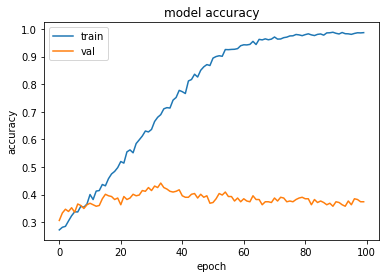

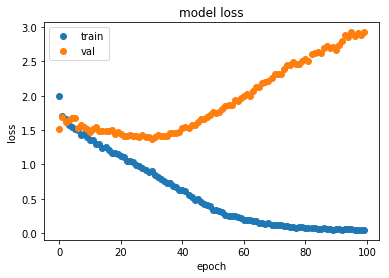

In [11]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'],'o')
plt.plot(history.history['val_loss'],'o')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [12]:
# evaluate model on entire training set
model = load_model('LSTM_model.hdf5')
model.evaluate(X_train_sub,y_train,batch_size=N_train)

2458/2458 [==============================] - 18s 8ms/step


[0.60377579927444458, 0.81122863292694092]

In [13]:
# evaluate model on test set
model.evaluate(X_test_sub,y_test,batch_size=N_test)

100/100 [==============================] - 1s 9ms/step


[1.4399468898773193, 0.46000000834465027]